In [1]:
# https://www.usgs.gov/landsat-missions/using-usgs-landsat-level-1-data-product

import sys
sys.path.append(r'C:\Users\Acer\Documents\Python Works\Satellite\Landsat\landsat_functions')
sys.path.append(r'C:\Users\Acer\Documents\Python Works\Satellite\plotting_functions')
sys.path.append(r'C:\Users\Acer\Documents\Python Works\cmaptxt')

from osgeo import gdal
import numpy as np
import os
import re
import math
import pyproj
from datetime import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.font_manager import FontProperties
from matplotlib.offsetbox import AnchoredText
from landsat_functions import *
from plotting_functions import set_map_extent
from cmaptxt import get_colormap

In [2]:
file = 'D:\\Landsat\\Noul Landsat-8\\LC08_L1GT_115048_20150510_20200909_02_T2_B10.tif'
#file = 'C:\\Landsat\\LC08_L1GT_115048_20150510_20200909_02_T2_B4.tif'
metadata_file = 'D:\\Landsat\\Noul Landsat-8\\LC08_L1GT_115048_20150510_20200909_02_T2_MTL.txt'
#file = 'C:\\Users\\Acer\\Documents\\Python Works\\Satellite\\Landsat\\LC09_L1GT_122049_20220927_20230327_02_T2_B10.tif'
#file = 'C:\\Users\\Acer\\Documents\\Python Works\\Satellite\\Landsat\\LC09_L1GT_122049_20220927_20230327_02_T2_B4.tif'
#metadata_file = 'LC09_L1GT_122049_20220927_20230327_02_T2_MTL.txt'
#file = 'C:\\Users\\Acer\\Documents\\Python Works\\Satellite\\Landsat\\LC08_L1GT_123046_20140718_20200911_02_T2_B10.tif'
#file = 'C:\\Users\\Acer\\Documents\\Python Works\\Satellite\\Landsat\\LC08_MERGED_L1GT_123046_20140718_20200911_02_T2_B10.tif'
#metadata_file = 'LC08_L1GT_123046_20140718_20200911_02_T2_MTL.txt'
#file = 'D:\\Landsat\\Ian Landsat-8\\LC08_L1GT_016042_20220928_20221005_02_T2_B10.tif'
#metadata_file = 'D:\\Landsat\\Ian Landsat-8\\LC08_L1GT_016042_20220928_20221005_02_T2_MTL.txt'
#file = 'D:\\Landsat\\Tauktae Landsat-8\\LC08_L1GT_148047_20210517_20210525_02_T2_B10.tif'
#metadata_file = 'D:\\Landsat\\Tauktae Landsat-8\\LC08_L1GT_148047_20210517_20210525_02_T2_MTL.txt'

raster = gdal.Open(file)

projection = raster.GetProjection()

# Extract the PCS EPSG code from the projection
epsg_match = re.search(r'AUTHORITY\["EPSG","(\d+)"\]\]$', projection)
if epsg_match:
    epsg_code = int(epsg_match.group(1))
    print(f"EPSG Code: {epsg_code}")
else:
    print("EPSG code not found in the projection.")

# Dimensions
raster.RasterXSize
raster.RasterYSize

# Number of bands
raster.RasterCount

# Metadata for the raster dataset
raster.GetMetadata()

# Read the raster band as separate variable
band = raster.GetRasterBand(1)
band_arr = band.ReadAsArray()

# Data type of the values
gdal.GetDataTypeName(band.DataType)

info = gdal.Info(file, deserialize=True)
print(info)

#raster = None
#band = None

#Extract info from filename
filename = os.path.basename(file)

landsat_number = int(filename[2:4])
satellite_name = 'LANDSAT-' + str(landsat_number)
print(satellite_name)

band_number = re.findall(r'\d+(?=\.\w+$)', filename)[0]

if satellite_name == 'LANDSAT-8':
    if int(band_number) in range(1, 10):
        sensor = 'OLI'
    else:
        sensor = 'TIRS'
elif satellite_name == 'LANDSAT-9':
    if int(band_number) in range(1, 10):
        sensor = 'OLI-2'
    else:
        sensor = 'TIRS-2'

print(band_number, sensor)

EPSG Code: 32651
Driver: GTiff/GeoTIFF
Files: D:\Landsat\Noul Landsat-8\LC08_L1GT_115048_20150510_20200909_02_T2_B10.tif
       D:\Landsat\Noul Landsat-8\LC08_L1GT_115048_20150510_20200909_02_T2_MTL.txt
Size is 7601, 7751
Coordinate System is:
PROJCRS["WGS 84 / UTM zone 51N",
    BASEGEOGCRS["WGS 84",
        ENSEMBLE["World Geodetic System 1984 ensemble",
            MEMBER["World Geodetic System 1984 (Transit)"],
            MEMBER["World Geodetic System 1984 (G730)"],
            MEMBER["World Geodetic System 1984 (G873)"],
            MEMBER["World Geodetic System 1984 (G1150)"],
            MEMBER["World Geodetic System 1984 (G1674)"],
            MEMBER["World Geodetic System 1984 (G1762)"],
            MEMBER["World Geodetic System 1984 (G2139)"],
            ELLIPSOID["WGS 84",6378137,298.257223563,
                LENGTHUNIT["metre",1]],
            ENSEMBLEACCURACY[2.0]],
        PRIMEM["Greenwich",0,
            ANGLEUNIT["degree",0.0174532925199433]],
        ID["EPSG",4326

In [3]:
# Read the metadata file and store its content in a string variable
with open(metadata_file, "r") as mtd_file:
    metadata_text = mtd_file.read()
    
    key_date = "DATE_ACQUIRED"
    key_time = "SCENE_CENTER_TIME"
    section_start = metadata_text.find("GROUP = IMAGE_ATTRIBUTES")
    section_end = metadata_text.find("END_GROUP = IMAGE_ATTRIBUTES", section_start)
    section_text = metadata_text[section_start:section_end]
    date = None
    time = None
    lines = section_text.split("\n")
    for line in lines:
        if key_date in line:
            date = line.split("=")[1].strip()
        elif key_time in line:
            time = line.split("=")[1].strip().strip('"')[:5]

    # Convert date and time strings to datetime objects
    date_object = datetime.strptime(date, "%Y-%m-%d").date()
    time_object = datetime.strptime(time, "%H:%M").time()
    combined_datetime = datetime.combine(date_object, time_object)
    formatted_dt = combined_datetime.strftime("%m-%d-%Y %H:%MZ")
    print(formatted_dt)
    
    # Extract calibration coefficients
    calibration_coefficients = extract_calibration_coefficients(band_number, metadata_text)
    print("Calibration Coefficients for band", band_number)
    for key, value in calibration_coefficients.items():
        print(key, "=", value)

    # Extract thermal constraints
    k1, k2 = extract_thermal_constraints(band_number, metadata_text)
    if k1 is not None and k2 is not None:
        print("Thermal Constraints for band", band_number)
        print("K1 constant:", k1)
        print("K2 constant:", k2)
    else:
        print("Thermal constraints for Band 10 not found in the metadata.")

05-10-2015 02:09Z
10
{'RADIANCE_MULT_BAND_10': 0.0003342, 'RADIANCE_ADD_BAND_10': 0.1, 'SUN_ELEVATION': 67.39973782, 'EARTH_SUN_DISTANCE': 1.0096042}
Calibration Coefficients for band 10
RADIANCE_MULT_BAND_10 = 0.0003342
RADIANCE_ADD_BAND_10 = 0.1
SUN_ELEVATION = 67.39973782
EARTH_SUN_DISTANCE = 1.0096042
Thermal Constraints for band 10
K1 constant: 774.8853
K2 constant: 1321.0789


In [4]:
if 'OLI' in sensor:
    toa = calculate_toa_reflectance(band_number, band_arr, calibration_coefficients)
else:
    toa = calculate_rad_bt(band_number, band_arr, calibration_coefficients, k1, k2)

Min:  -125.63290425622392 Max:  22.034502383758138
Min:  -91.47879813124712 Max:  22.034502383758138


In [5]:
# Get geotransform information
geotransform = raster.GetGeoTransform()
x_res = geotransform[1]
y_res = geotransform[5]
x_min = geotransform[0]
y_max = geotransform[3]

# Generate x and y coordinates for the image
x = np.arange(x_min, x_min + (raster.RasterXSize * x_res), x_res)
y = np.arange(y_max, y_max - (raster.RasterYSize * abs(y_res)), y_res)
#extent = [x[0], x[-1], y[0], y[-1]]
extent = [x[0], x[-1], y[-1], y[0]]
print(extent)

# Create a Cartopy projection using the raster's coordinate reference system (CRS)
crs = ccrs.epsg(epsg_code)

center_lat_lon = [17.33, 123.05]
#center_lat_lon = [15.2, 111.8]
#center_lat_lon = [19.45, 111.9]
#center_lat_lon = [18.9, 121.4]
#center_lat_lon = [26.32, -82.66]
max_range = 50
lon_limits, lat_limits = set_map_extent(center_lat_lon[1], center_lat_lon[0], max_range)
min_lon = lon_limits[3]-0.05
max_lon = lon_limits[1]+0.05
min_lat = lat_limits[2]
max_lat = lat_limits[0]

# Define the desired latitude and longitude extent
desired_extent_latlon = [min_lon, max_lon, min_lat, max_lat]
print(desired_extent_latlon)

# Convert the desired extent to UTM coordinates using pyproj
utm_transformer = pyproj.Transformer.from_crs(4326, epsg_code, always_xy=True)
desired_extent_utm = utm_transformer.transform(desired_extent_latlon[:2], desired_extent_latlon[2:])
print(desired_extent_utm)

[388485.0, 616485.0, 1800915.0, 2033415.0]
[122.52888019092941, 123.57111980907058, 16.88026669185173, 17.779733308148266]
([449820.27564217726, 560535.6798990346], [1866369.5232616076, 1965908.4975220207])


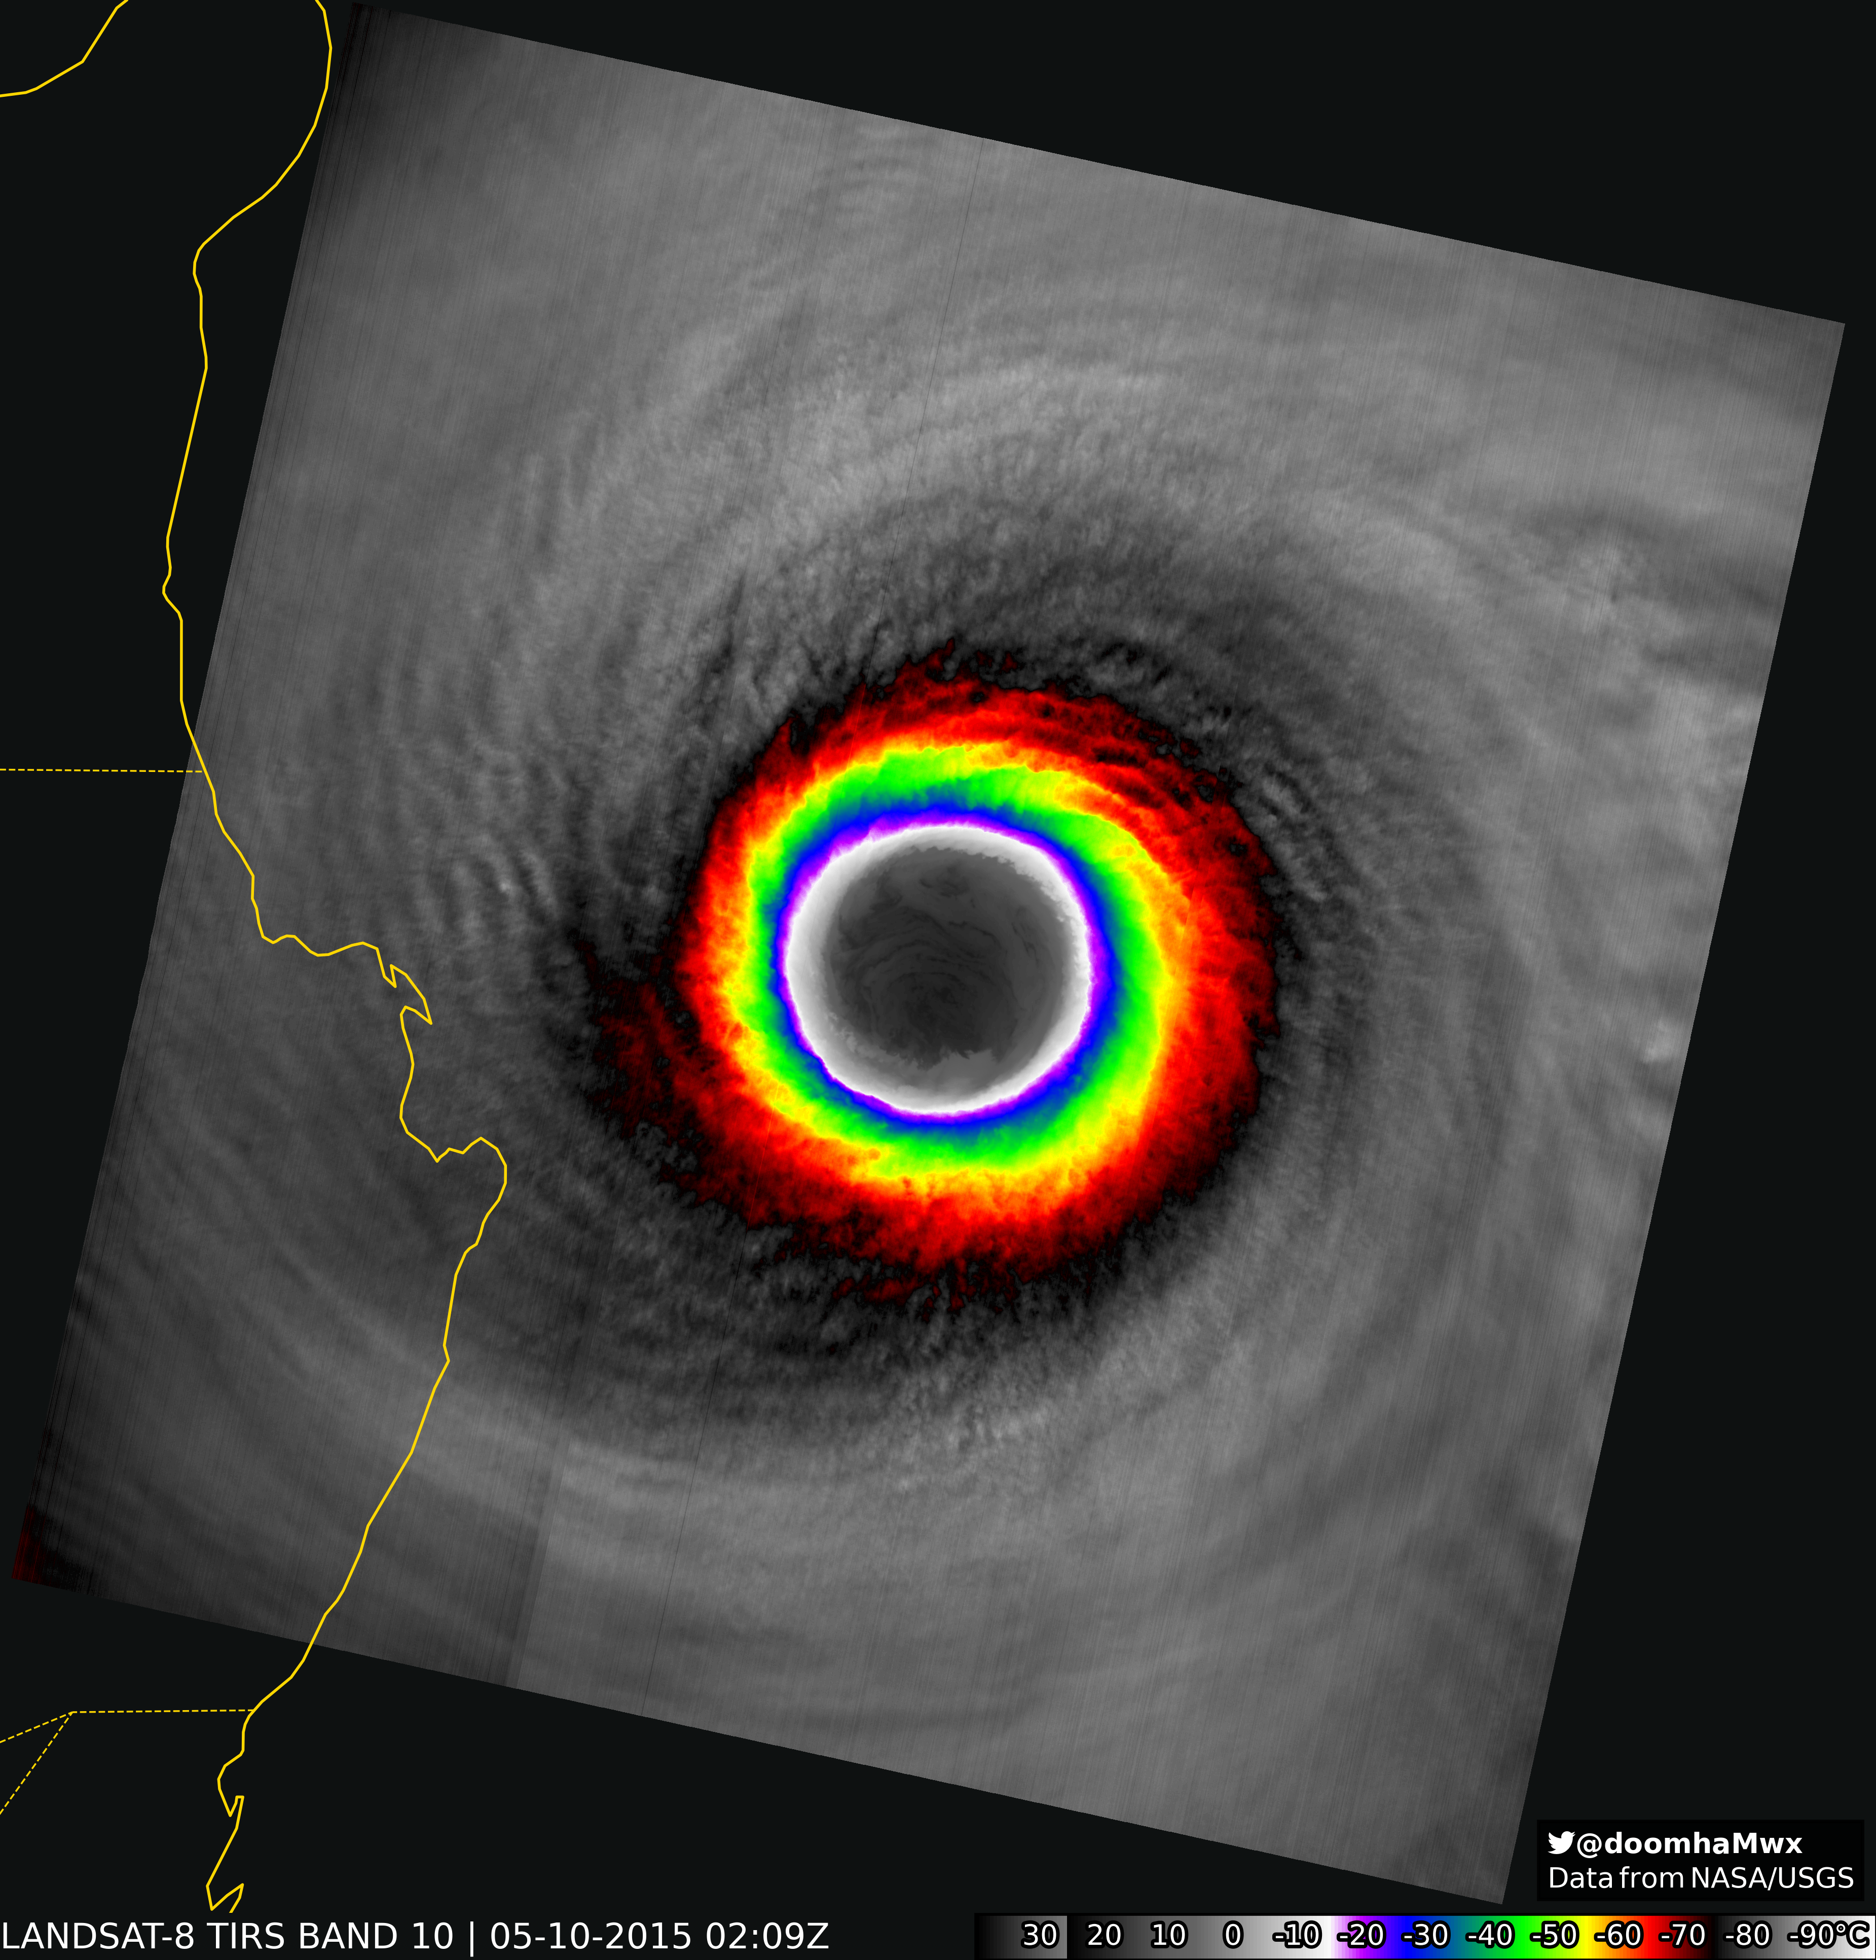

In [6]:
%config InlineBackend.print_figure_kwargs = {'pad_inches':0}
plt.rcParams['text.color'] = 'white'
plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'

# Create a figure and axes with the Cartopy projection
fig, ax = plt.subplots(figsize=(10,10), dpi=500, facecolor='#0e1111', subplot_kw={'projection': crs})
ax.set_axis_off()

# Plot the raster image on the map
if 'OLI' in sensor:
    #cmap = 'gray'
    #norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cmap = get_colormap('../colormaps/vis-enh.txt')
    norm = mpl.colors.Normalize(vmin=0, vmax=2)
    tick_values = [0.0, 1.0]
    tick_labels = ['', '']
else:
    cmap = get_colormap('../Colormaps/rbtop.txt')
    norm = mpl.colors.Normalize(vmin=-100, vmax=40)
    tick_values = [30, 20, 10, 0, -10, -20, -30, -40, -50, -60, -70, -80, -90, -96]
    tick_labels = [str(t) for t in tick_values[:-1]] + ['°C']

im = ax.imshow(toa, cmap=cmap, norm=norm, extent=extent, transform=crs)

color='gold'
states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines', 
                                                scale='10m', facecolor='none', lw=0.5, linestyle='--')
ax.add_feature(states_provinces, edgecolor=color)
ax.add_feature(cfeature.BORDERS, edgecolor=color, lw=0.8)
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), lw=0.8, edgecolor=color)

# Set the extent of the plot using the desired extent in UTM coordinates
#ax.set_extent([desired_extent_utm[0][0], desired_extent_utm[0][1], desired_extent_utm[1][0], desired_extent_utm[1][1]], crs=crs)

shapefile2 = list(shpreader.Reader('../Shapefiles/SouthChinaSeaIslands/SouthChinaSeaIslands.shp').geometries())
ax.add_geometries(shapefile2, ccrs.PlateCarree(), edgecolor=color, facecolor='none', linewidth=0.8)

# Create new axes according to image position
cax = fig.add_axes([ax.get_position().x0 + (1 - 0.48) * ax.get_position().width,
                    ax.get_position().y0-0.0185,
                    ax.get_position().width*0.48, 0.018])

clb = plt.colorbar(im, cax=cax, orientation="horizontal", ticks=tick_values)
clb.ax.tick_params(labelsize=8, size=0)
if 'OLI' not in sensor:
    clb.ax.invert_xaxis()
clb.ax.set_xticklabels(tick_labels)

# Get the bounding box of the colorbar
bbox = clb.ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())

# Set custom tick labels inside the colorbar with yellow font color and black border
for position, label in zip(tick_values, tick_labels):
    text = clb.ax.annotate(label, xy=(position, 0.5), xytext=(0, 0), textcoords='offset points',
                           ha='center', va='center', fontsize=8, color='white', clip_on=True)
    text.set_path_effects([pe.withStroke(linewidth=2, foreground='black')])

clb.ax.set_xticklabels([]) # Hide the default tick labels from the colorbar
clb.ax.yaxis.set_label_coords(0.5, -3)  # Adjust label position

# Add text to the left of the colorbar
text_x = ax.get_position().x0
text_y = ax.get_position().y0 - 0.010
fig.text(text_x, text_y, satellite_name + ' ' + sensor + ' BAND ' + str(band_number)+' | '+formatted_dt, va='center', ha='left', fontsize=10)

fp = FontProperties(fname=r"C:/Windows/fontawesome-free-6.4.0-desktop/otfs/Font Awesome 6 Brands-Regular-400.otf")
twitter_icon = '\uf099'
twitter_user = '@doomhaMwx'

text = (twitter_icon+r"$\bf{" + twitter_user + "}$\n"
        r"$\mathrm{Data\, from\, NASA/USGS}$")
text_box = AnchoredText(text, frameon=True, loc=4, pad=0.3, prop=dict(fontsize=8, fontproperties=fp))
plt.setp(text_box.patch, facecolor='black', alpha=0.8)
ax.add_artist(text_box)

plt.show()
plt.close()